In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

log_dir = os.path.join('logs', '2022-03-05')
log_file = os.path.join(log_dir, 'log_2022-03-05-07-20-19_train.sample.csv_e5_b1_sum.csv')

def visualize(log_path):
    log_df = pd.read_csv(log_path)
    epoch = list(log_df['epoch'].unique())
    epochs = [i for i in range(len(epoch))]
    subplot_id = 320
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    for e in epochs:
        e_df = log_df[log_df['epoch'] == e]
        len_e = len(e_df)
        loss_prom = list(e_df['loss_prom'])
        loss_ss = list(e_df['loss_ss'])
        loss_polya = list(e_df['loss_polya'])
        steps = [(k+1) for k in range(0, len_e)]
        subplot_id += 1
        ax = fig.add_subplot(subplot_id)
        ax.plot(steps, loss_prom, label='loss prom')
        ax.plot(steps, loss_ss, label='loss ss')
        ax.plot(steps, loss_polya, label='loss polya')
        ax.set_title('epoch {}'.format(e+1))
        ax.set_xlabel('steps')
        ax.set_ylabel('loss')
        ax.legend()
        
    plt.subplots_adjust(top=1.5, bottom=1, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()



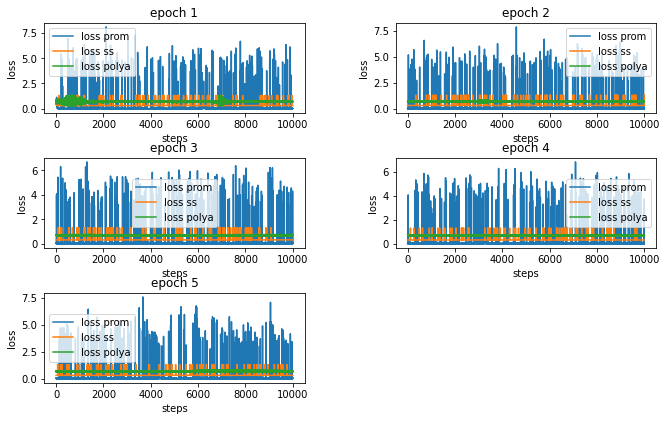

In [9]:
visualize(log_file)

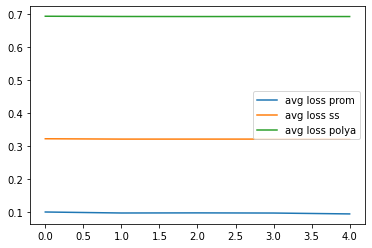

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
def visualize_avg_loss_per_epoch(log_path):
    if not os.path.exists(log_path):
        raise FileNotFoundError("File {} not found.".format(log_path))

    df = pd.read_csv(log_path)
    epochs = list(df['epoch'].unique())
    avg_loss_prom_by_epoch = []
    avg_loss_ss_by_epoch = []
    avg_loss_polya_by_epoch = []
    for e in epochs:
        edf = df[df['epoch'] == e]
        avg_loss_prom_by_epoch.append(edf['loss_prom'].mean())
        avg_loss_ss_by_epoch.append(edf['loss_ss'].mean())
        avg_loss_polya_by_epoch.append(edf['loss_polya'].mean())

    fig, ax = plt.subplots()
    ax.plot(epochs, avg_loss_prom_by_epoch, label="avg loss prom")
    ax.plot(epochs, avg_loss_ss_by_epoch, label="avg loss ss")
    ax.plot(epochs, avg_loss_polya_by_epoch, label="avg loss polya")   
    ax.legend()

    plt.show()

log_dir = os.path.join('logs', '2022-03-05')
log_file = os.path.join(log_dir, 'log_2022-03-05-07-20-19_train.sample.csv_e5_b1_sum.csv')
visualize_avg_loss_per_epoch(log_file)


In [3]:
"""
Create confusion matrix for MTL.
"""
from multitask_learning import init_model_mtl
from data_dir import pretrained_3kmer_dir
from utils.mtl import create_dataloader_from_csv
from transformers import BertTokenizer
import os
from tqdm import tqdm
import torch

model = init_model_mtl(pretrained_3kmer_dir)
model.eval()

tokenizer = BertTokenizer.from_pretrained(pretrained_3kmer_dir)
eval_log = os.path.join("logs", "mtl", "eval", "2022-03-17", "log.csv")
if os.path.exists(eval_log):
    os.remove(eval_log)
os.makedirs(os.path.dirname(eval_log), exist_ok=True)
log = open(eval_log, 'x')
log.write("pred_prom,label_prom,pred_ss,label_ss,pred_polya,label_polya\n")

val_csv = os.path.join("workspace", "mtl", "validation.sample.csv")
dataloader = create_dataloader_from_csv(val_csv, tokenizer, batch_size=1)
for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    input_ids, attn_mask, token_type_ids, label_prom, label_ss, label_polya = tuple(t for t in batch)
    preds = model(input_ids, attn_mask)
    pred_prom = preds["prom"]
    pred_ss = preds["ss"]
    pred_polya = preds["polya"]

    pred_prom_val, pred_prom_index = torch.max(pred_prom, dim=1)
    actual_prom = label_prom.float().item()
    predicted_prom = torch.round(pred_prom_val).item()

    pred_ss_val, pred_ss_index = torch.max(pred_ss, dim=1)
    pred_ss_index = pred_ss_index.item()
    label_ss = label_ss.item()

    pred_polya_val, pred_polya_index = torch.max(pred_polya, dim=1)
    pred_polya_index = pred_polya_index.item()
    label_polya = label_polya.item()
    
    log.write(f"{predicted_prom},{actual_prom},{pred_ss_index},{label_ss},{pred_polya_index},{label_polya}\n")

    #print(pred_prom, pred_prom_index, label_prom)
    #print(pred_ss, pred_ss_index, label_ss)
    #print(pred_polya, pred_polya_index, label_polya)

log.close()

100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


In [5]:
"""
Create confusion matrix.
"""
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
eval_log = os.path.join("logs", "mtl", "eval", "2022-03-17", "log.csv")
df = pd.read_csv(eval_log)
pred_prom = list(df['pred_prom'])
label_prom = list(df['label_prom'])
cf_matrix_prom = confusion_matrix(pred_prom, label_prom)
print(cf_matrix_prom)
pred_ss = list(df['pred_ss'])
label_ss = list(df['label_ss'])
cf_matrix_ss = confusion_matrix(pred_ss, label_ss)
print(cf_matrix_ss)
pred_polya = list(df['pred_polya'])
label_polya = list(df['label_polya'])
cf_matrix_polya = confusion_matrix(pred_polya, label_polya)
print(cf_matrix_polya)


[[98  1]
 [ 1  0]]
[[ 3  5]
 [48 44]]
[[16 11]
 [35 38]]


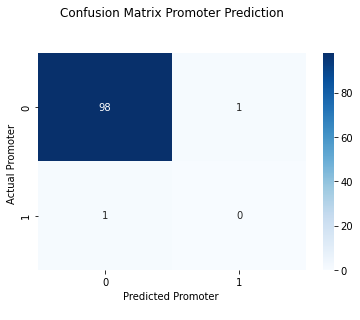

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_prom, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Promoter Prediction\n\n')
ax.set_xlabel('Predicted Promoter \n')
ax.set_ylabel('Actual Promoter ')

## Display the visualization of the Confusion Matrix.
plt.show()

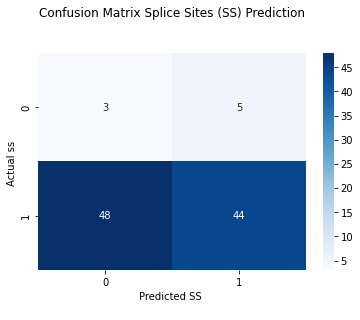

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_ss, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix Splice Sites (SS) Prediction\n\n')
ax.set_xlabel('Predicted SS \n')
ax.set_ylabel('Actual SS ')

## Display the visualization of the Confusion Matrix.
plt.show()

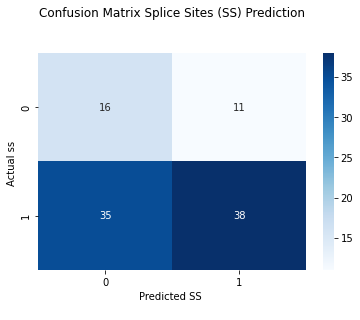

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix_polya, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix PolyA Prediction\n\n')
ax.set_xlabel('Predicted PolyA \n')
ax.set_ylabel('Actual PolyA ')

## Display the visualization of the Confusion Matrix.
plt.show()